In [25]:
import numpy as np
import torch
import torch_directml as dml
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, \
    mean_absolute_percentage_error, median_absolute_error, r2_score, mean_poisson_deviance, d2_absolute_error_score

from DataPrep import load_prepared_data

In [26]:
NUM_LAGS = 10
SPLIT_RATIO = 0.9

number_of_epochs = 10
learning_rate = 0.001
batch_size = 100
hidden_size = 4
num_stacked_layers = 1
input_size = NUM_LAGS
output_size = 1

In [27]:
if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device("cuda")
elif dml.is_available():
    print(f"Using {dml.device_name(dml.default_device())} with DirectML")
    device = dml.device()
else:
    print("Using CPU")
    device = torch.device("cpu")
# device = torch.device("cpu")

Using AMD Radeon RX 5700 XT with DirectML


In [28]:
class MyDataset(Dataset):
    def __init__(self, dataset):
        unshifted_x = dataset[:, 1:]

        x = deepcopy(np.flip(unshifted_x, axis=1))
        y = dataset[:, 0]

        self.x = torch.from_numpy(x).float().reshape(-1, NUM_LAGS, 1)
        self.y = torch.from_numpy(y).float().reshape(-1, 1)

        self.number_of_samples = len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.number_of_samples


In [29]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_stacked_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        return out

In [30]:
dataset = load_prepared_data(NUM_LAGS)
split_index = int(len(dataset) * SPLIT_RATIO)

In [31]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(dataset)

In [32]:
train_dataset = MyDataset(deepcopy(scaled[:split_index, :]))
test_dataset = MyDataset(deepcopy(scaled[split_index:, :]))

In [33]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([100, 10, 1]) torch.Size([100, 1])


In [35]:
model = LSTM(input_size, hidden_size, num_stacked_layers).to(device)

In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
print(model)

LSTM(
  (lstm): LSTM(10, 4, batch_first=True)
  (fc1): Linear(in_features=4, out_features=1, bias=True)
)


In [38]:
for epoch in range(number_of_epochs):
    running_loss = 0
    for i, (x, y) in enumerate(train_loader):
        x = x.reshape(-1, 1, input_size).to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{number_of_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/10], Loss: 0.0076
Epoch [2/10], Loss: 0.0013
Epoch [3/10], Loss: 0.0001
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


In [39]:
with torch.no_grad():
    model.eval()
    running_loss = 0

    for i, (x, y) in enumerate(test_loader):
        x = x.reshape(-1, 1, input_size).to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)
        running_loss += loss.item()
    print(f'Average Loss: {running_loss / len(test_loader.dataset):.4f}')

Average Loss: 0.0006


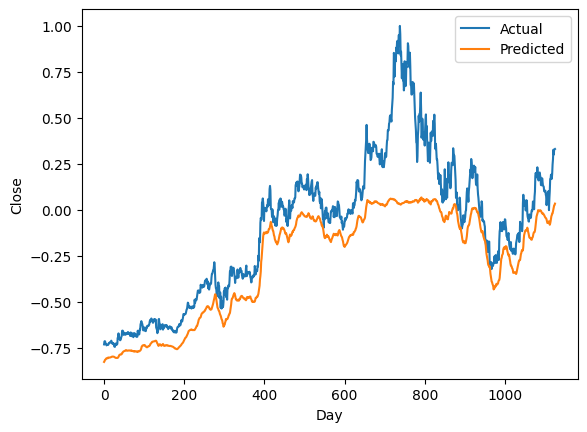

In [48]:
with torch.no_grad():
    model.eval()
    predicted = model(test_dataset.x.reshape(-1, 1, input_size).to(device)).to('cpu').numpy()

plt.plot(test_dataset.y, label='Actual')
plt.plot(predicted, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [41]:
def descale(data):
    flattened = data.flatten()

    dummies = np.zeros((len(flattened), scaled.shape[1]))
    dummies[:, 0] = flattened
    descaled = scaler.inverse_transform(dummies)[:len(flattened), 0]
    return descaled

In [42]:
descaled_predictions = descale(predicted)
descaled_real = descale(test_dataset.y)

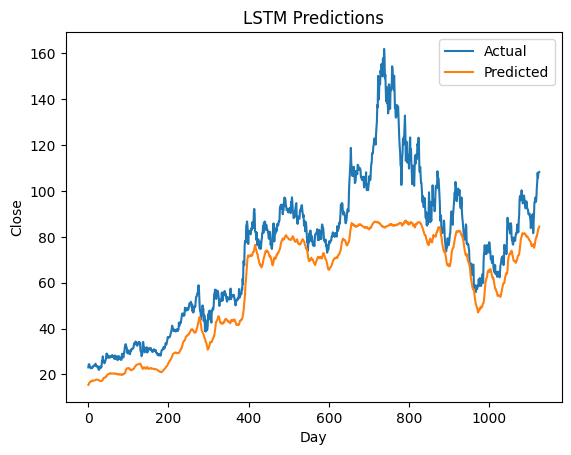

In [50]:
plt.plot(descaled_real, label='Actual')
plt.plot(descaled_predictions, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('LSTM Predictions')
plt.savefig('./plots/LSTM_Predictions.png')
plt.show()

In [44]:
print(f'Explained Variance Score: {explained_variance_score(descaled_real, descaled_predictions):.4f}')
print(f'Mean Absolute Error: {mean_absolute_error(descaled_real, descaled_predictions):.4f}')

Explained Variance Score: 0.8504
Mean Absolute Error: 14.9403


In [45]:
print(f'Mean Squared Error: {mean_squared_error(descaled_real, descaled_predictions):.4f}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(descaled_real, descaled_predictions):.4f}')

Mean Squared Error: 370.2860
Mean Absolute Percentage Error: 0.2015


In [46]:
print(f'Median Absolute Error: {median_absolute_error(descaled_real, descaled_predictions):.4f}')
print(f'R2 Score: {r2_score(descaled_real, descaled_predictions):.4f}')

Median Absolute Error: 11.2525
R2 Score: 0.6233


In [47]:
print(f'Mean Poisson Deviance: {mean_poisson_deviance(descaled_real, descaled_predictions):.4f}')
print(f'D2 Absolute Error Score: {d2_absolute_error_score(descaled_real, descaled_predictions):.4f}')

Mean Poisson Deviance: 4.6086
D2 Absolute Error Score: 0.4090
